## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller_beta import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-06 10:22:18.581180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-06 10:22:18.581211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-06 10:22:28.930044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-06 10:22:28.930090: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-06 10:22:28.930124: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tall12): /proc/driver/nvidia/version does not exist
2022-05-06 10:22:28.930610: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 11s 32ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building a preprocessing routine

In [6]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Resnet8 Student model 

In [7]:
print("============== Building Student Network Resnet8 ! =============")

student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

student = tf.keras.Sequential([
    preprocessing,
    student,   
])



student_scratch = tf.keras.models.clone_model(student)

print("")

============== Building Student Network Resnet8 ! =============



## Building callbacks

In [8]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [9]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 82s 50ms/step - sparse_categorical_accuracy: 0.4580 - student_loss: 1.4685 - loss: 1.6111 - val_sparse_categorical_accuracy: 0.4210 - val_student_loss: 3.4542 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6221 - student_loss: 1.0626 - loss: 1.1819 - val_sparse_categorical_accuracy: 0.5838 - val_student_loss: 2.5014 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6875 - student_loss: 0.8919 - loss: 0.9989 - val_sparse_categorical_accuracy: 0.6313 - val_student_loss: 2.4284 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7257 - student_loss: 0.7872 - loss: 0.8858 - val_sparse_categorical_accuracy: 0.7047 - val_student_loss: 1.3466 - lr: 0.1000
Epoch 5/100
1562/1562 [==============================] - 71s 45ms/step - sparse_cate

Epoch 35/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9171 - student_loss: 0.2394 - loss: 0.2833 - val_sparse_categorical_accuracy: 0.8343 - val_student_loss: 1.4020 - lr: 1.0000e-03
Epoch 36/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9164 - student_loss: 0.2390 - loss: 0.2828
Epoch 36: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9164 - student_loss: 0.2391 - loss: 0.2829 - val_sparse_categorical_accuracy: 0.8343 - val_student_loss: 1.4028 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9185 - student_loss: 0.2361 - loss: 0.2799 - val_sparse_categorical_accuracy: 0.8346 - val_student_loss: 1.3991 - lr: 1.0000e-04
Epoch 38/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical

1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9187 - student_loss: 0.2373 - loss: 0.2811 - val_sparse_categorical_accuracy: 0.8350 - val_student_loss: 1.3996 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.2375 - loss: 0.2813 - val_sparse_categorical_accuracy: 0.8347 - val_student_loss: 1.3968 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.2363 - loss: 0.2800 - val_sparse_categorical_accuracy: 0.8342 - val_student_loss: 1.3993 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.9179 - student_loss: 0.2360 - loss: 0.2796 - val_sparse_categorical_accuracy: 0.8345 - val_student_loss: 1.4010 - lr: 1.0000e-06
Epoch 71/100
1562/1562 [==============================] - 71s 46ms/step - spa

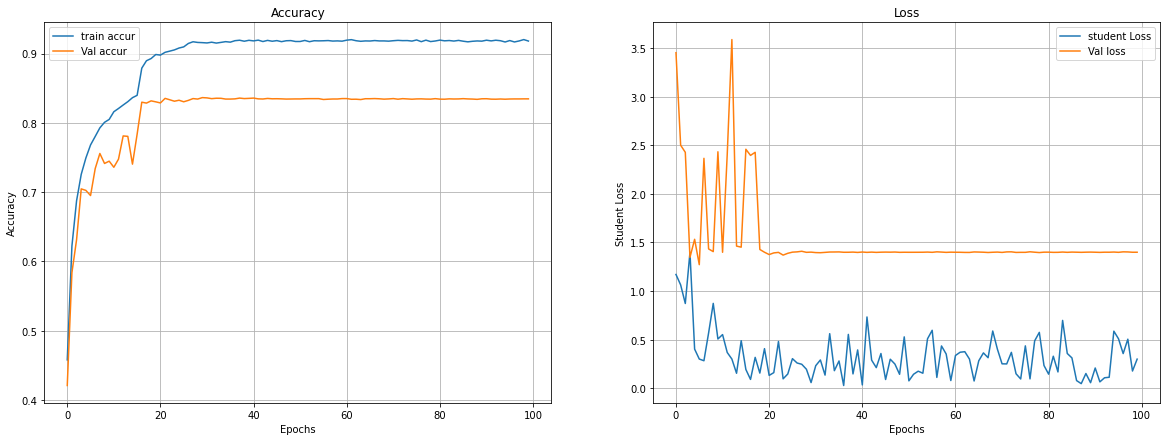

Saving model 


2022-05-06 12:21:48.748745: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 75s 46ms/step - sparse_categorical_accuracy: 0.4656 - student_loss: 1.4514 - loss: 1.7308 - val_sparse_categorical_accuracy: 0.4008 - val_student_loss: 2.4435 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6213 - student_loss: 1.0610 - loss: 1.2915 - val_sparse_categorical_accuracy: 0.5764 - val_student_loss: 1.4331 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6804 - student_loss: 0.9070 - loss: 1.1140 - val_sparse_categorical_accuracy: 0.6000 - val_student_loss: 1.5281 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7214 - student_loss: 0.8039 - loss: 0.9937 - val_sparse_categorical_accuracy: 0.6951 - v

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9259 - student_loss: 0.2131 - loss: 0.2838 - val_sparse_categorical_accuracy: 0.8345 - val_student_loss: 1.4121 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9250 - student_loss: 0.2110 - loss: 0.2808 - val_sparse_categorical_accuracy: 0.8361 - val_student_loss: 1.4093 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9264 - student_loss: 0.2125 - loss: 0.2823 - val_sparse_categorical_accuracy: 0.8368 - val_student_loss: 1.4077 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9267 - student_loss: 0.2106 - loss: 0.2799 - val_sparse_categorical_accuracy: 0.8359 - val_student_loss: 1.3996 - lr: 1.0000e-03
Epoch 38/100
1562/1562 [==============================] - 71s 46ms/step - spa

1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9292 - student_loss: 0.2048 - loss: 0.2726 - val_sparse_categorical_accuracy: 0.8350 - val_student_loss: 1.4024 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9290 - student_loss: 0.2034 - loss: 0.2714 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4010 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9288 - student_loss: 0.2047 - loss: 0.2726 - val_sparse_categorical_accuracy: 0.8343 - val_student_loss: 1.3926 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9302 - student_loss: 0.2009 - loss: 0.2687 - val_sparse_categorical_accuracy: 0.8353 - val_student_loss: 1.4017 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 71s 45ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8351 - student_loss: 1.5669

 =============== History Plot ===============


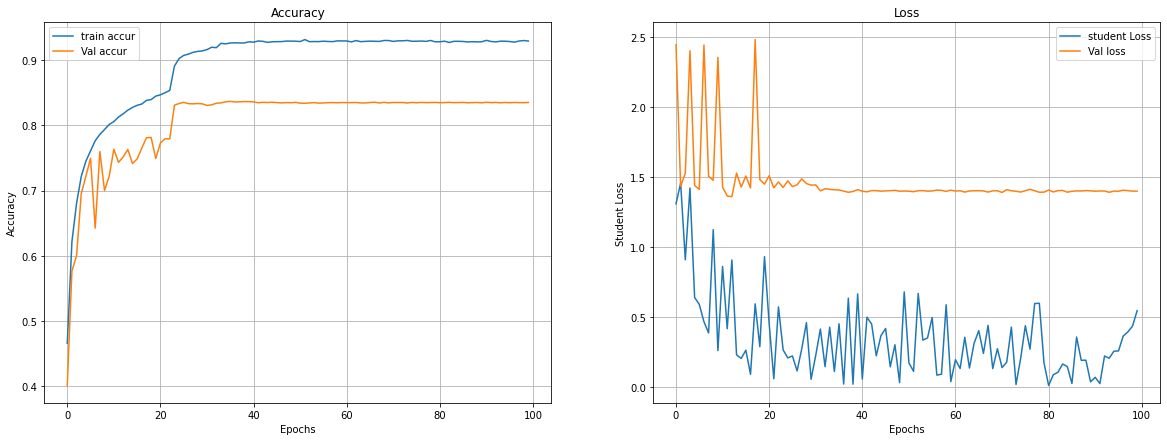

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 76s 47ms/step - sparse_categorical_accuracy: 0.4270 - student_loss: 1.5512 - loss: 1.9832 - val_sparse_categorical_accuracy: 0.4868 - val_student_loss: 2.4427 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.5975 - student_loss: 1.1350 - loss: 1.4889 - val_sparse_categorical_accuracy: 0.5835 - val_student_loss: 2.5647 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6569 - student_loss: 0.9758 - loss: 1.2909 - val_sparse_categorical_accuracy: 0.5418 - val_student_loss: 1.4757 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7022 - student_loss: 0.8627 - loss: 1.1487 - val_sparse_categorical_accura

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9067 - student_loss: 0.2711 - loss: 0.3832 - val_sparse_categorical_accuracy: 0.8316 - val_student_loss: 1.4620 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2724 - loss: 0.3838 - val_sparse_categorical_accuracy: 0.8310 - val_student_loss: 1.4634 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9077 - student_loss: 0.2700 - loss: 0.3811 - val_sparse_categorical_accuracy: 0.8297 - val_student_loss: 1.4621 - lr: 1.0000e-03
Epoch 36/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9074 - student_loss: 0.2710 - loss: 0.3824
Epoch 36: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2695 - loss: 0.3805 - val_sparse_categorical_accuracy: 0.8305 - val_student_loss: 1.4612 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2686 - loss: 0.3795 - val_sparse_categorical_accuracy: 0.8308 - val_student_loss: 1.4618 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.9094 - student_loss: 0.2663 - loss: 0.3770 - val_sparse_categorical_accuracy: 0.8310 - val_student_loss: 1.4621 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.9070 - student_loss: 0.2699 - loss: 0.3808 - val_sparse_categorical_accuracy: 0.8307 - val_student_loss: 1.4597 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 71s 45ms/step - spa

313/313 [==============================] - 4s 14ms/step - sparse_categorical_accuracy: 0.8300 - student_loss: 1.5738

 =============== History Plot ===============


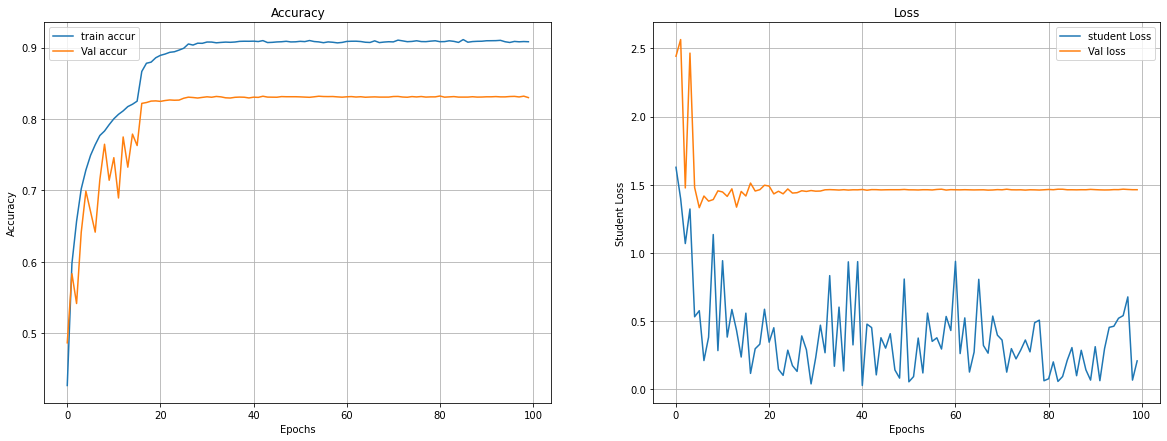

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4607 - student_loss: 1.4710 - loss: 2.0214 - val_sparse_categorical_accuracy: 0.4423 - val_student_loss: 2.5019 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6148 - student_loss: 1.1049 - loss: 1.5544 - val_sparse_categorical_accuracy: 0.5549 - val_student_loss: 2.7489 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6674 - student_loss: 0.9647 - loss: 1.3650 - val_sparse_categorical_accuracy: 0.6376 - val_student_loss: 1.5294 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7059 - student_loss: 0.8645 - loss: 1.2289 - val_sparse_categorical_accura

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9188 - student_loss: 0.2408 - loss: 0.3615
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9188 - student_loss: 0.2415 - loss: 0.3623 - val_sparse_categorical_accuracy: 0.8289 - val_student_loss: 1.5493 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9230 - student_loss: 0.2229 - loss: 0.3404 - val_sparse_categorical_accuracy: 0.8308 - val_student_loss: 1.4955 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9239 - student_loss: 0.2244 - loss: 0.3426 - val_sparse_categorical_accuracy: 0.8309 - val_student_loss: 1.4981 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9248

Epoch 66/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9289 - student_loss: 0.2112 - loss: 0.3263 - val_sparse_categorical_accuracy: 0.8311 - val_student_loss: 1.5101 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9275 - student_loss: 0.2146 - loss: 0.3304 - val_sparse_categorical_accuracy: 0.8321 - val_student_loss: 1.5388 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.9266 - student_loss: 0.2151 - loss: 0.3307 - val_sparse_categorical_accuracy: 0.8322 - val_student_loss: 1.5294 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9257 - student_loss: 0.2177 - loss: 0.3332 - val_sparse_categorical_accuracy: 0.8318 - val_student_loss: 1.5218 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 70s 45

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.8315 - student_loss: 1.5636

 =============== History Plot ===============


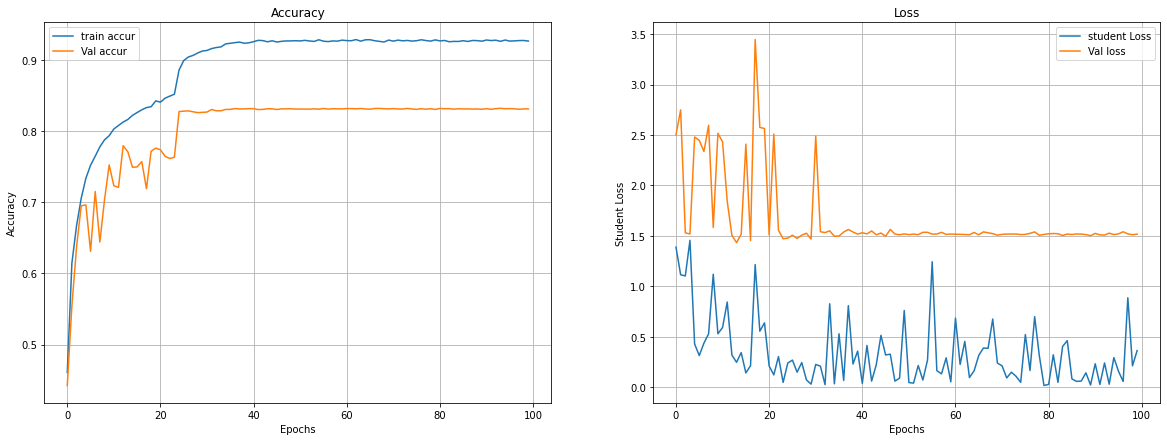

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4490 - student_loss: 1.5047 - loss: 2.1940 - val_sparse_categorical_accuracy: 0.4127 - val_student_loss: 3.3754 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6154 - student_loss: 1.1081 - loss: 1.6540 - val_sparse_categorical_accuracy: 0.5560 - val_student_loss: 2.6575 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6727 - student_loss: 0.9639 - loss: 1.4434 - val_sparse_categorical_accuracy: 0.5887 - val_student_loss: 1.4923 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.7075 - student_loss: 0.8684 - loss: 1.3030 - val_sparse_categorical_accura

1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9187 - student_loss: 0.2417 - loss: 0.3871 - val_sparse_categorical_accuracy: 0.8357 - val_student_loss: 1.4753 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9193 - student_loss: 0.2414 - loss: 0.3857 - val_sparse_categorical_accuracy: 0.8361 - val_student_loss: 1.4611 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9183 - student_loss: 0.2396 - loss: 0.3828 - val_sparse_categorical_accuracy: 0.8365 - val_student_loss: 1.4681 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9201 - student_loss: 0.2395 - loss: 0.3827 - val_sparse_categorical_accuracy: 0.8370 - val_student_loss: 1.4612 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 72s 46ms/step - spa

1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9217 - student_loss: 0.2331 - loss: 0.3739 - val_sparse_categorical_accuracy: 0.8357 - val_student_loss: 1.4818 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9224 - student_loss: 0.2281 - loss: 0.3685 - val_sparse_categorical_accuracy: 0.8356 - val_student_loss: 1.4795 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.9214 - student_loss: 0.2331 - loss: 0.3742 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4817 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.9220 - student_loss: 0.2304 - loss: 0.3710 - val_sparse_categorical_accuracy: 0.8356 - val_student_loss: 1.4807 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 71s 46ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8353 - student_loss: 1.5750

 =============== History Plot ===============


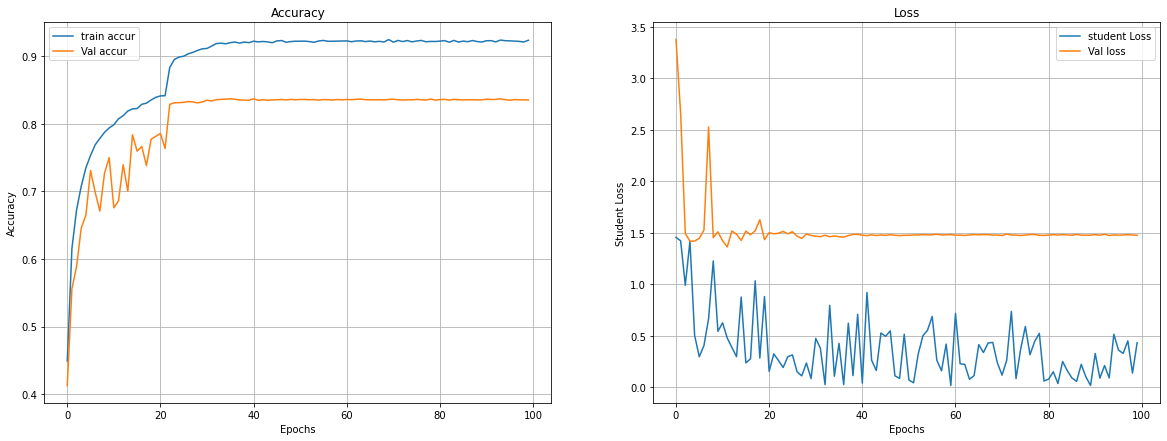

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 76s 46ms/step - sparse_categorical_accuracy: 0.4440 - student_loss: 1.5231 - loss: 2.3472 - val_sparse_categorical_accuracy: 0.4554 - val_student_loss: 2.3357 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.6063 - student_loss: 1.1432 - loss: 1.7971 - val_sparse_categorical_accuracy: 0.5701 - val_student_loss: 2.6047 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.6674 - student_loss: 0.9863 - loss: 1.5543 - val_sparse_categorical_accuracy: 0.5429 - val_student_loss: 1.3036 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.7059 - student_loss: 0.8847 - loss: 1.3939 - val_sparse_categorical_accura

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.8948 - student_loss: 0.3197 - loss: 0.5219
Epoch 33: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.8948 - student_loss: 0.3195 - loss: 0.5217 - val_sparse_categorical_accuracy: 0.8323 - val_student_loss: 1.4466 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.8966 - student_loss: 0.3123 - loss: 0.5134 - val_sparse_categorical_accuracy: 0.8326 - val_student_loss: 1.4468 - lr: 1.0000e-04
Epoch 35/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.8962 - student_loss: 0.3152 - loss: 0.5163 - val_sparse_categorical_accuracy: 0.8329 - val_student_loss: 1.4546 - lr: 1.0000e-04
Epoch 36/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.8956 - student_loss: 0.3166 - loss: 0.5171 - val_sparse_categorical_accuracy: 0.8317 - val_student_loss: 1.4503 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 71s 46ms/step - sparse_categorical_accuracy: 0.8978 - student_loss: 0.3120 - loss: 0.5124 - val_sparse_categorical_accuracy: 0.8322 - val_student_loss: 1.4493 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.8966 - student_loss: 0.3198 - loss: 0.5209 - val_sparse_categorical_accuracy: 0.8318 - val_student_loss: 1.4505 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.8973 - student_loss: 0.3157 - loss: 0.5163 - val_sparse_categorical_accuracy: 0.8323 - val_student_loss: 1.4420 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 71s 46ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8321 - student_loss: 1.5537

 =============== History Plot ===============


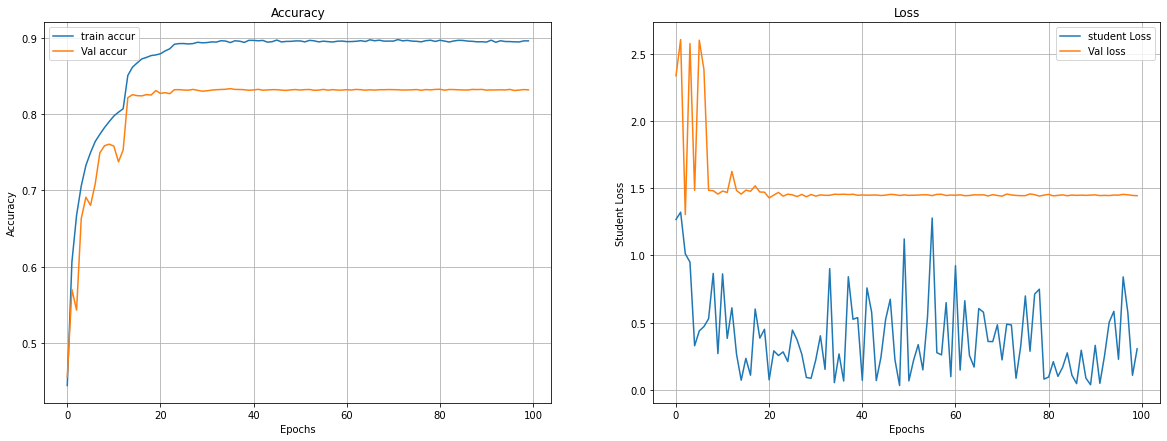

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4591 - student_loss: 1.4995 - loss: 2.4384 - val_sparse_categorical_accuracy: 0.4161 - val_student_loss: 4.5916 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6283 - student_loss: 1.1058 - loss: 1.8268 - val_sparse_categorical_accuracy: 0.6074 - val_student_loss: 2.6624 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.6872 - student_loss: 0.9527 - loss: 1.5692 - val_sparse_categorical_accuracy: 0.6257 - val_student_loss: 2.4966 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7215 - student_loss: 0.8702 - loss: 1.4226 - val_sparse_categorical_accura

1562/1562 [============================>.] - ETA: 0s - sparse_categorical_accuracy: 0.9215 - student_loss: 0.2433 - loss: 0.4247
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.9214 - student_loss: 0.2444 - loss: 0.4258 - val_sparse_categorical_accuracy: 0.8330 - val_student_loss: 1.4377 - lr: 0.0100
Epoch 35/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9222 - student_loss: 0.2359 - loss: 0.4133 - val_sparse_categorical_accuracy: 0.8343 - val_student_loss: 1.4602 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9254 - student_loss: 0.2260 - loss: 0.4025 - val_sparse_categorical_accuracy: 0.8345 - val_student_loss: 1.4617 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9258

Epoch 66/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9293 - student_loss: 0.2178 - loss: 0.3910 - val_sparse_categorical_accuracy: 0.8348 - val_student_loss: 1.4677 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9268 - student_loss: 0.2240 - loss: 0.3981 - val_sparse_categorical_accuracy: 0.8348 - val_student_loss: 1.4641 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 73s 46ms/step - sparse_categorical_accuracy: 0.9279 - student_loss: 0.2204 - loss: 0.3940 - val_sparse_categorical_accuracy: 0.8352 - val_student_loss: 1.4644 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9257 - student_loss: 0.2233 - loss: 0.3972 - val_sparse_categorical_accuracy: 0.8347 - val_student_loss: 1.4650 - lr: 1.0000e-06
Epoch 70/100
1562/1562 [==============================] - 73s 47

313/313 [==============================] - 4s 11ms/step - sparse_categorical_accuracy: 0.8342 - student_loss: 1.5669

 =============== History Plot ===============


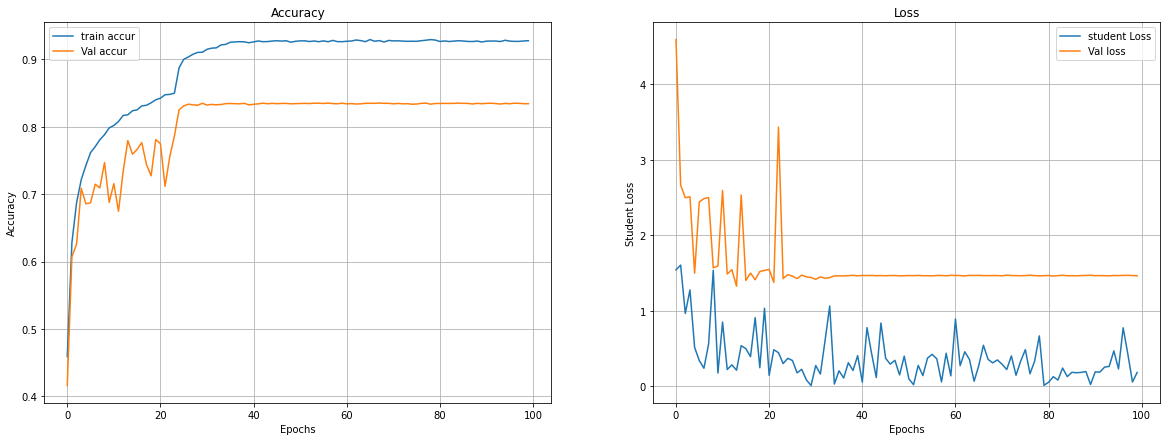

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 79s 48ms/step - sparse_categorical_accuracy: 0.4413 - student_loss: 1.5472 - loss: 2.6324 - val_sparse_categorical_accuracy: 0.3849 - val_student_loss: 2.4726 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6011 - student_loss: 1.1884 - loss: 2.0419 - val_sparse_categorical_accuracy: 0.5272 - val_student_loss: 2.6398 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6587 - student_loss: 1.0461 - loss: 1.7899 - val_sparse_categorical_accuracy: 0.4928 - val_student_loss: 1.5064 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6974 - student_loss: 0.9496 - loss: 1.6169 - val_sparse_categorical_accura

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9086 - student_loss: 0.2826 - loss: 0.5037 - val_sparse_categorical_accuracy: 0.8319 - val_student_loss: 1.4918 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9080 - student_loss: 0.2831 - loss: 0.5031 - val_sparse_categorical_accuracy: 0.8327 - val_student_loss: 1.4844 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9095 - student_loss: 0.2842 - loss: 0.5035 - val_sparse_categorical_accuracy: 0.8324 - val_student_loss: 1.4910 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9087 - student_loss: 0.2827 - loss: 0.5027 - val_sparse_categorical_accuracy: 0.8330 - val_student_loss: 1.4995 - lr: 1.0000e-03
Epoch 37/100
1562/1562 [==============================] - 78s 50ms/step - spa

1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.9093 - student_loss: 0.2803 - loss: 0.4974 - val_sparse_categorical_accuracy: 0.8340 - val_student_loss: 1.4950 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9112 - student_loss: 0.2757 - loss: 0.4926 - val_sparse_categorical_accuracy: 0.8342 - val_student_loss: 1.4926 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9119 - student_loss: 0.2745 - loss: 0.4913 - val_sparse_categorical_accuracy: 0.8342 - val_student_loss: 1.4959 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9106 - student_loss: 0.2763 - loss: 0.4930 - val_sparse_categorical_accuracy: 0.8336 - val_student_loss: 1.4874 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 77s 49ms/step - spa

313/313 [==============================] - 4s 13ms/step - sparse_categorical_accuracy: 0.8338 - student_loss: 1.5436

 =============== History Plot ===============


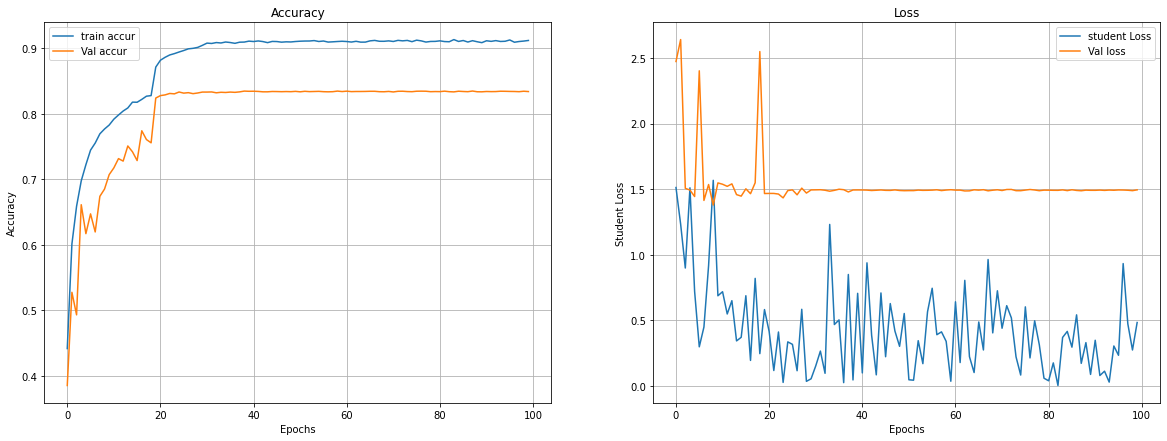

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 76s 46ms/step - sparse_categorical_accuracy: 0.4494 - student_loss: 1.5365 - loss: 2.7294 - val_sparse_categorical_accuracy: 0.4552 - val_student_loss: 2.5384 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.6077 - student_loss: 1.1779 - loss: 2.1035 - val_sparse_categorical_accuracy: 0.5539 - val_student_loss: 2.5870 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.6621 - student_loss: 1.0419 - loss: 1.8447 - val_sparse_categorical_accuracy: 0.5294 - val_student_loss: 1.6552 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.7031 - student_loss: 0.9460 - loss: 1.6661 - val_sparse_categorical_accura

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9054 - student_loss: 0.2998 - loss: 0.5509 - val_sparse_categorical_accuracy: 0.8356 - val_student_loss: 1.4853 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9049 - student_loss: 0.2986 - loss: 0.5488 - val_sparse_categorical_accuracy: 0.8373 - val_student_loss: 1.4900 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9067 - student_loss: 0.2958 - loss: 0.5446 - val_sparse_categorical_accuracy: 0.8366 - val_student_loss: 1.4939 - lr: 1.0000e-03
Epoch 36/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2942 - loss: 0.5422 - val_sparse_categorical_accuracy: 0.8370 - val_student_loss: 1.4851 - lr: 1.0000e-03
Epoch 37/100
1563/1562 [==============================] - ETA: 0s - sparse_ca

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9061 - student_loss: 0.2950 - loss: 0.5427 - val_sparse_categorical_accuracy: 0.8371 - val_student_loss: 1.4864 - lr: 1.0000e-06
Epoch 66/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9067 - student_loss: 0.2907 - loss: 0.5379 - val_sparse_categorical_accuracy: 0.8370 - val_student_loss: 1.4872 - lr: 1.0000e-06
Epoch 67/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9078 - student_loss: 0.2933 - loss: 0.5409 - val_sparse_categorical_accuracy: 0.8370 - val_student_loss: 1.4899 - lr: 1.0000e-06
Epoch 68/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9080 - student_loss: 0.2907 - loss: 0.5379 - val_sparse_categorical_accuracy: 0.8363 - val_student_loss: 1.4886 - lr: 1.0000e-06
Epoch 69/100
1562/1562 [==============================] - 74s 47ms/step - spa

313/313 [==============================] - 4s 12ms/step - sparse_categorical_accuracy: 0.8371 - student_loss: 1.5758

 =============== History Plot ===============


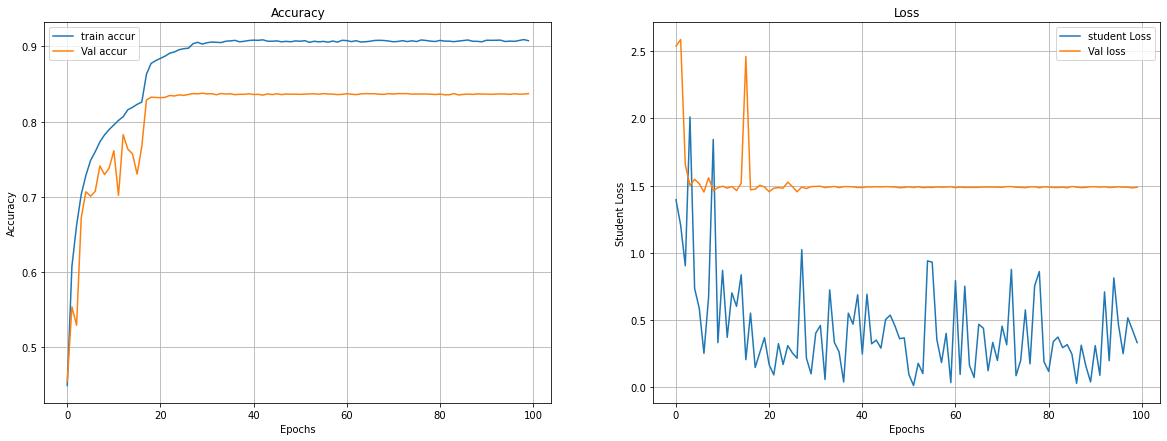

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [10]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_beta_{a}_temp5"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)
    student = tf.keras.Sequential([
        preprocessing,
        student,   
    ])

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_beta{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_beta{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_beta_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")